В этом блокноте мы обсудим частотное представление изображений. Кроме того, мы увидим, как преобразования в частотной области меняют исходное изображение.



Для начала установим необходимую версию библиотеки и подключим то, чем будем пользоватья в дальнейшем.

In [1]:
!pip install opencv-python==4.4.0.42

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 11.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.6.0.66
    Uninstalling opencv-python-4.6.0.66:
      Successfully uninstalled opencv-python-4.6.0.66


In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 300

# **Преобразование Фурье в Python и фильтрация в чатотной области**

Начнем с того, что научимся осуществлять дикретное преобразование Фурье средствами Python.

Для начала считаем черно-белое изображение и выведем его на экран. Если исходное изображение оказывается цветным, то придется работать с каждым его каналом отдельно.

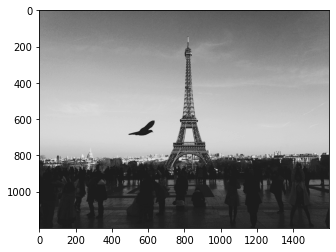

In [3]:
img = cv2.imread('img.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap = 'gray')

Проведем преобразование Фурье и визуализируем результат. Двумерное дискретное преобразование Фурье (на самом деле — быстрое преобразование Фурье или fast Fourier transform) в библиотеке `numpy` может быть выполнено с использованием функции `np.fft.fft2()`, аргументом которой служит исходное изображение. 

In [4]:
f = np.fft.fft2(img)
print(f[10, 12])

(-303609.54502521426-287581.0858228238j)


В результатемы получаем двумерную матрицу того же размера, что и матрица, отвечающая исходному изображению, элементы которой теперь, вообще говоря, комплексные.

Для удобства визуализации (что общепринято), переместим компоненту, отвечающую нулевой частоте (`f[0][0]`), в центр. Это можно сделать автоматичеки, используя функцию `np.fft.fftshift()`, аргументом которой служит полученное ранее преобразование Фурье `f`. Легко проверить, что так как изображение имеет размеры $1200 \times 1600$, то `fshift[600][800] = f[0][0]`.

In [5]:
fshift = np.fft.fftshift(f)
print(fshift[600][800] == f[0][0])

True


Для визуализации преобразования Фурье, заменим все элементы матрицы их модулями — амплитудами. И... 

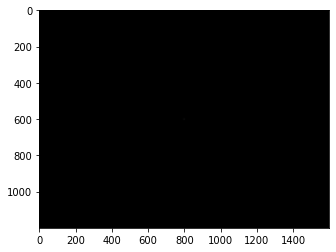

In [6]:
magnitude_spectrum = np.abs(fshift)
plt.imshow(magnitude_spectrum, cmap = 'gray')

Ничего не видно, кроме некоторого белого вкрапления посередине. Все дело в том, что различие в значениях амплитуд очень велико.

In [ ]:
print('min:', np.min(magnitude_spectrum), 'max:', np.max(magnitude_spectrum))
print(magnitude_spectrum[600][800])

min: 10.815443187335951 max: 242373590.0
242373590.0


Отметим отдельно, что максимальная амплитуда отвечает нулевой частоте (в центре смещенного преобразования Фурье). Применим логарифмическое шкалирование (общепринятный стандартный прием при визуализации преобразования Фурье). Сами преобразования могут несколько отличатья, но это не будет давать существенных различий при визуализации. Единица под логарифмом добавлена для того, чтобы избежать очень маленьких значений логарифма, когда его аргумент близок к $0$ (хотя в нашей ситуации такого не будет, что видно из выведенного выше значения `min`).

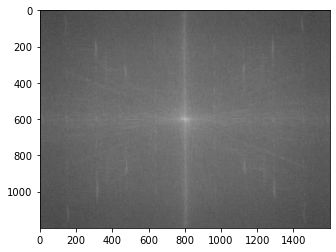

In [ ]:
magnitude_spectrum = np.log(1+np.abs(fshift))
plt.imshow(magnitude_spectrum, cmap = 'gray')

Итак, что мы видим на полученной картинке? Чем светлее точка — тем больше у нее амплитуда, то есть тем больше информации она несет. Чем дальше мы удаляемся от центра — тем  выше частота. Светлые регионы отвечают более низким частотам, а темные — более высоким. Мы видим, что в общем и целом низкие частоты несут больше информации, чем высокие. 

За что отвечает частота? Высокие частоты отвечают за резкие изменения яркости пикселей, а низкие, наоборот, за плавные изменения яркости пикселей. 

Давайте теперь попробуем убрать основные низкие частоты — занулим их амплитуду, присвоив всем элементам матрицы `fshift`, близким к центру, значение $0$.

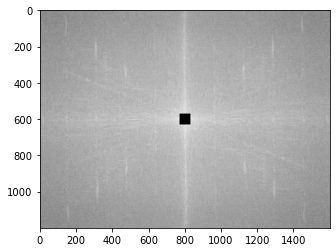

In [ ]:
fshift[600 -  30 : 600 + 30, 800-30 : 800 + 30] = 0
magnitude_spectrum = np.log(1+np.abs(fshift))
plt.imshow(magnitude_spectrum, cmap = 'gray')

Чтобы получить разумную картинку, применим обратное преобразование Фурье (быстрое — inverse fast Fourier transform), используя функцию `np.fft.ifft2()`, аргументом которой служит преобразование Фурье. Предварительно нужно "сдвинуть все назад", используя `np.fft.ifftshift()`.

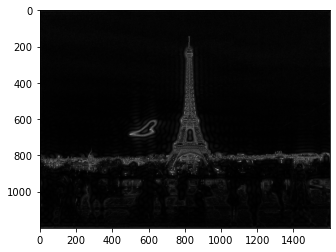

In [ ]:
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
plt.imshow(img_back, cmap = 'gray')

Мы видим, как отчетливо стали видны границы изображений: вся монохромность ушла. Тем самым, мы легко сегментировали Эйфелеву башню, летящую птицу и границу городчких кварталов, уходящих за горизонт.

Логично задатья вопросом: а чему отвечают вертикальная и горизонтальная линии, проходящие через центр изображения амплитуд? Давайте посмотрим, что изменится, если мы их затемним. Сначала проверим, что все сделали правильно.

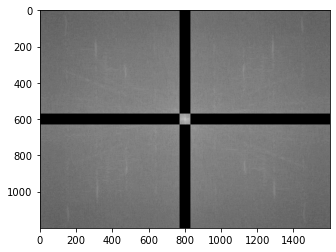

In [ ]:
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
fshift[600 - 30 : 600 + 30, 0 : 800 - 30] = fshift[600 - 30 : 600 + 30, 800+30 : 1600] = 0
fshift[0 : 600 - 30, 800 - 30 : 800 + 30] = fshift[600 + 30 : 1200, 800 - 30 : 800 + 30] = 0
magnitude_spectrum = np.log(1+np.abs(fshift))
plt.imshow(magnitude_spectrum, cmap = 'gray')

Вернемся к привычному для глаза изображению.

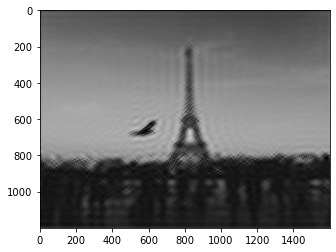

In [ ]:
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
plt.imshow(img_back, cmap = 'gray')

Итак, мы увеличили резкость выделяющихся объектов.

# **Градиенты изображений и детектирование границ**



Для определения границ изображения, бывает полезно построить так называемые градиенты изображений. Для использования оператора Лапласа, достаточно воспользоваться следующим кодом:

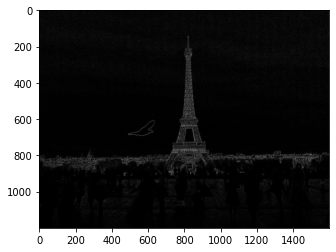

In [47]:
img = cv2.imread('img.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
laplacian = cv2.Laplacian(img, -1)
plt.imshow(laplacian,cmap = 'gray')

Видно, как четко отображаются границы всех объектов. В лекциях также рассказывается про операторы Собеля. Ниже можно видеть результаты применения этих операторов отдельно по первой координате, по второй, и по двум сразу.

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb8a31758b0>,
 <matplotlib.image.AxesImage at 0x7fb8a27ad7c0>)

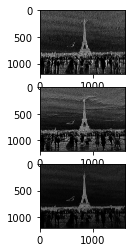

In [ ]:
sobel_x = cv2.Sobel(img, -1, 1, 0, ksize = 5)
sobel_y = cv2.Sobel(img, -1, 0, 1, ksize = 5)
sobel_full = cv2.Sobel(img, -1, 1, 1, ksize = 5)
plt.subplot(3,1,1),plt.imshow(sobel_x, cmap = 'gray')
plt.subplot(3,1,2),plt.imshow(sobel_y, cmap = 'gray')
plt.subplot(3,1,3),plt.imshow(sobel_full, cmap = 'gray')

Алгоритм детектора краев Кенни позволяет успешно находить краяи зображения. Применить его можно, например, следующим образом.

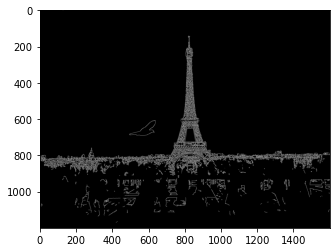

In [ ]:
canny = cv2.Canny(img, 100, 200)
plt.imshow(canny, cmap = 'gray')

In [7]:
# Task 1.

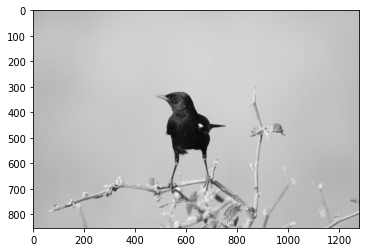

In [9]:
img = cv2.imread('img_1.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap = 'gray')

In [10]:
f = np.fft.fft2(img)
print(f[149, 403])

(1014.483535345929+2023.9761113024383j)


In [11]:
f.shape

(853, 1280)

In [12]:
img.shape

(853, 1280)

In [13]:
fshift = np.fft.fftshift(f)
print(fshift[853 // 2][1280 // 2] == f[0][0])

True


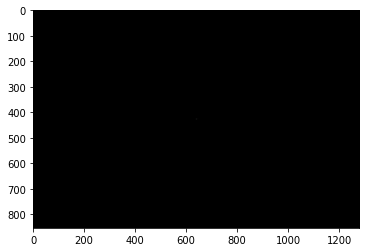

In [14]:
magnitude_spectrum = np.abs(fshift)
plt.imshow(magnitude_spectrum, cmap = 'gray')

In [15]:
print('min:', np.min(magnitude_spectrum), 'max:', np.max(magnitude_spectrum))
print(magnitude_spectrum[600][800])

min: 3.4629555609212144 max: 208075295.0
2431.753400072836


In [16]:
magnitude_spectrum = np.log(1+np.abs(fshift))

In [17]:
magnitude_spectrum.max() - magnitude_spectrum.min()

17.65759934378317

In [19]:
h, w = img.shape

In [22]:
fshift[h // 2 -  40 : h // 2 + 40, w // 2 - 40 : w // 2 + 40].shape

(80, 80)

True


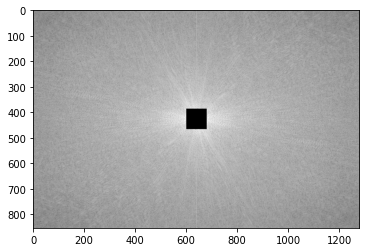

In [23]:
fshift = np.fft.fftshift(f)
print(fshift[853 // 2][1280 // 2] == f[0][0])
fshift[h // 2 -  40 : h // 2 + 40, w // 2 - 40 : w // 2 + 40] = 0
magnitude_spectrum = np.log(1+np.abs(fshift))
plt.imshow(magnitude_spectrum, cmap = 'gray')

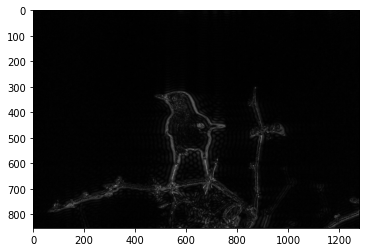

In [25]:
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
plt.imshow(img_back, cmap = 'gray')

In [27]:
img_back[669][428]

0.46104341833254

In [28]:
# Task 2.

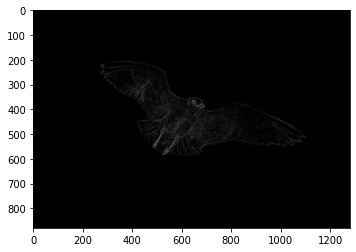

In [63]:
img = cv2.imread('img_2.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
laplacian = cv2.Laplacian(img, -1)
plt.imshow(laplacian,cmap = 'gray')

In [64]:
laplacian.sum()

6934950

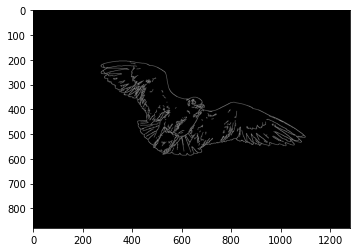

In [70]:
img = cv2.imread('img_2.jpeg')

canny = cv2.Canny(img, 100, 200)
plt.imshow(canny, cmap = 'gray')

In [69]:
canny.sum()

3128085